<h1> Data Augmentations -- MixUp, CutMix</h1>
    
Baseline to beat -- 86.7% <br>
Best score -- 89.6% (MixUp + Fit w/ Flat Cosine Annealing + Ranger (Lookahead + Rectified Adam)

CutMix might be better suited to other categories

<br><br>

In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from ranger import *

from CinemaNet.train_utils import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *
from CinemaNet.blend import *
from CinemaNet.custom_head import *

import wandb

## Load Dataset

In [3]:
img_size = to_film_ar(150)

In [4]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Long,Medium Close-Up,Close-Up,Medium Close-Up,Medium
Path: .;

Test: None

6

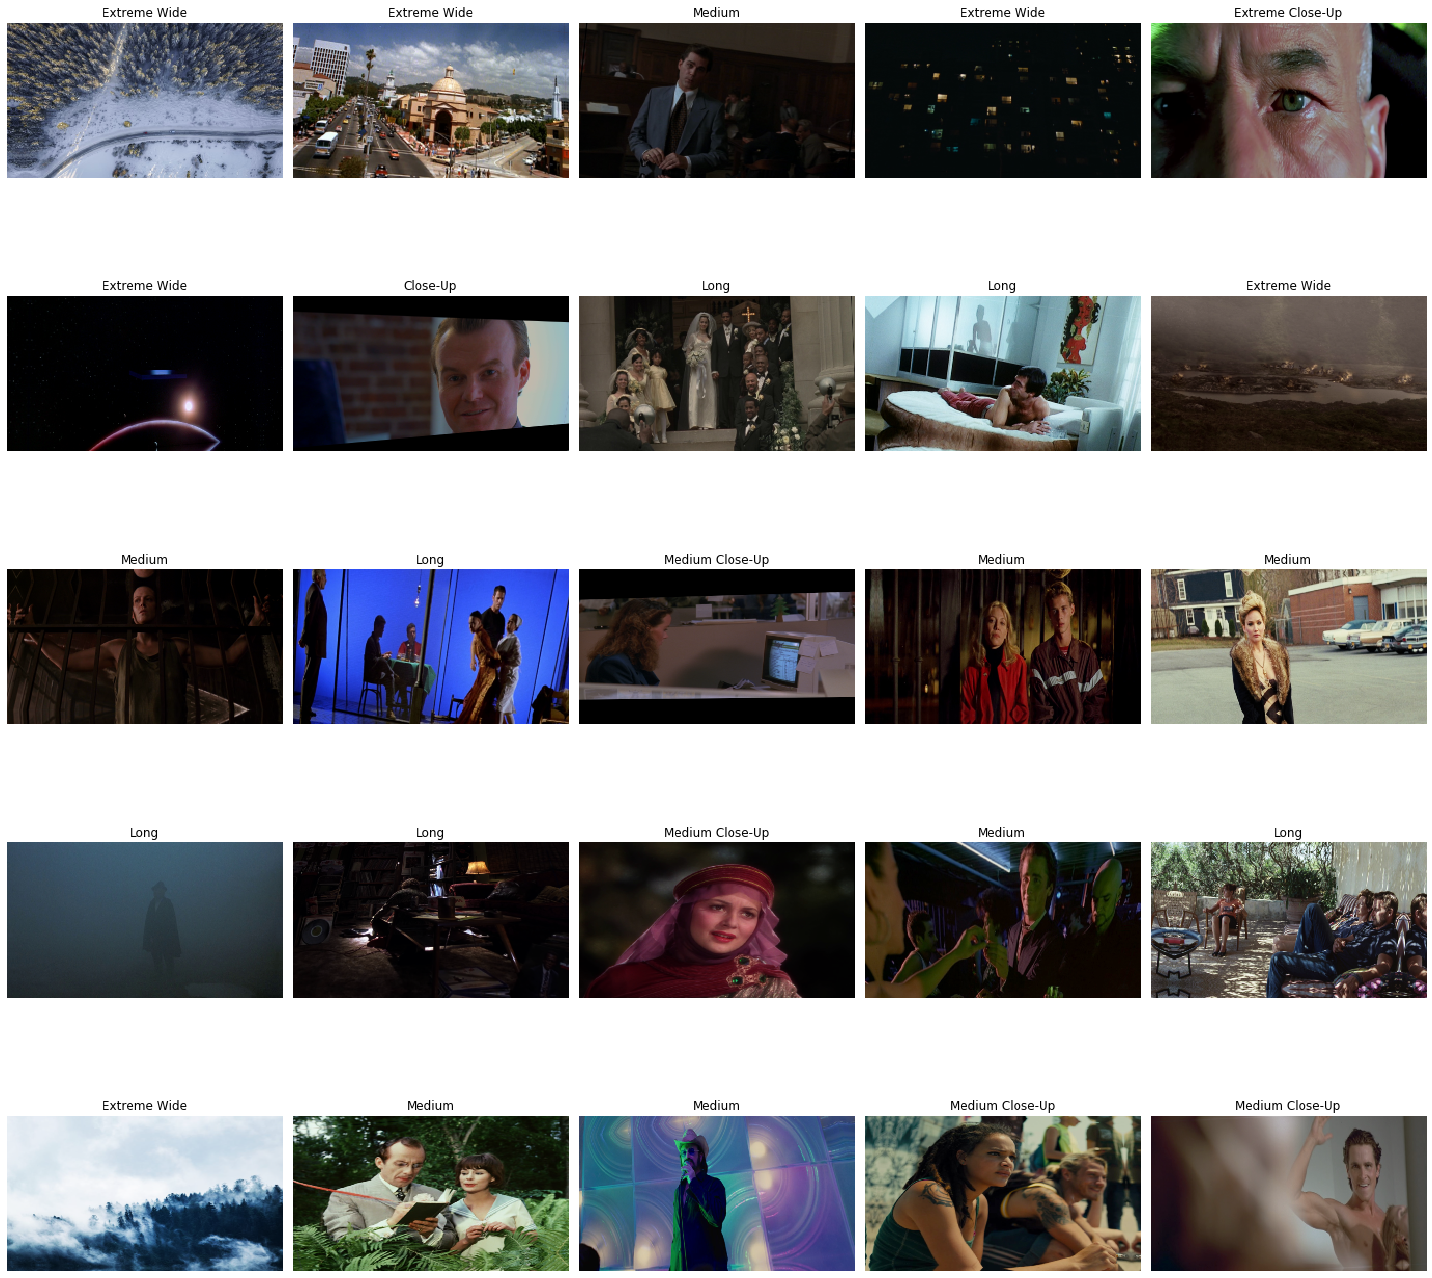

In [5]:
data.c
data.show_batch()

## Adding CutMix

In [18]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=metrics)
learn = learn.blend(size=0.4, blend_type='cut')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.20E-02


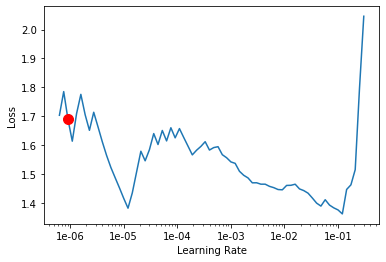

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(10, 1e-3, callbacks=[SaveModelCallback(learn, monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.322859,0.969217,0.618357,0.606267,0.652691,00:41
1,1.133699,0.711299,0.728824,0.736438,0.765046,00:41
2,0.962022,0.656860,0.773591,0.773924,0.785666,00:41
3,0.836942,0.655392,0.767150,0.769179,0.803225,00:39
4,0.728765,0.519365,0.804831,0.806133,0.820942,00:40
5,0.682508,0.554435,0.801288,0.792847,0.829229,00:40
6,0.620020,0.487186,0.826731,0.825949,0.847955,00:41
7,0.573463,0.497551,0.825121,0.825646,0.850673,00:43
8,0.541047,0.473331,0.830596,0.827234,0.855074,00:40
9,0.515328,0.472856,0.830596,0.825895,0.853047,00:42


Better model found at epoch 0 with accuracy value: 0.6183574795722961.
Better model found at epoch 1 with accuracy value: 0.7288244962692261.
Better model found at epoch 2 with accuracy value: 0.7735909819602966.
Better model found at epoch 4 with accuracy value: 0.8048309087753296.
Better model found at epoch 6 with accuracy value: 0.8267310857772827.
Better model found at epoch 8 with accuracy value: 0.8305957913398743.


## MixUp

In [23]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=metrics)
learn = learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.92E-03


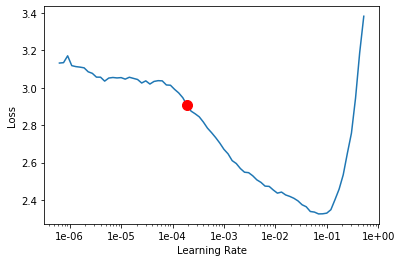

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(8, 1e-3, callbacks=[SaveModelCallback(learn, monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.167230,0.808234,0.683736,0.690536,0.730294,00:39
1,1.751770,0.666207,0.752979,0.758514,0.781001,00:41
2,1.537310,0.593858,0.790338,0.792112,0.819351,00:41
3,1.352651,0.511917,0.806441,0.803955,0.835649,00:41
4,1.187870,0.429428,0.837681,0.838470,0.860892,00:38
5,1.070130,0.449685,0.829630,0.831035,0.860369,00:39
6,1.016831,0.417883,0.845089,0.846166,0.866221,00:39
7,0.979157,0.422939,0.843156,0.843148,0.867686,00:40


Better model found at epoch 0 with accuracy value: 0.6837359070777893.
Better model found at epoch 1 with accuracy value: 0.752979040145874.
Better model found at epoch 2 with accuracy value: 0.7903381586074829.
Better model found at epoch 3 with accuracy value: 0.8064412474632263.
Better model found at epoch 4 with accuracy value: 0.8376811742782593.
Better model found at epoch 6 with accuracy value: 0.845088541507721.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-05


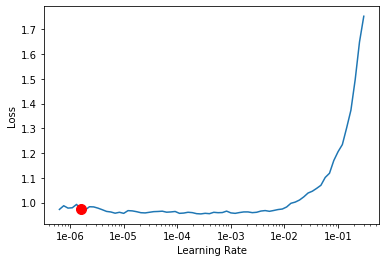

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.974294,0.411149,0.846377,0.845883,0.870055,00:43
1,0.986000,0.433878,0.837359,0.840242,0.865426,00:42
2,0.939720,0.419252,0.847021,0.847751,0.865776,00:42
3,0.946609,0.413837,0.850886,0.855736,0.864920,00:41
4,0.909722,0.387544,0.857971,0.858168,0.873699,00:42
5,0.892408,0.427610,0.846055,0.839606,0.869697,00:40
6,0.868858,0.382826,0.858937,0.857299,0.875622,00:40
7,0.834748,0.399554,0.854750,0.855390,0.878297,00:43
8,0.819711,0.384406,0.864734,0.862112,0.883163,00:42
9,0.800964,0.371967,0.876329,0.872479,0.890461,00:43


In [31]:
learn.fit_one_cycle(30, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.757101,0.368332,0.873752,0.869564,0.891456,00:43
1,0.746216,0.366128,0.872142,0.869469,0.889659,00:42
2,0.740448,0.361197,0.873430,0.872058,0.888072,00:42
3,0.734673,0.378865,0.864734,0.862687,0.883259,00:42
4,0.737916,0.373663,0.876973,0.876153,0.890870,00:41
5,0.749673,0.372904,0.868599,0.861775,0.890373,00:42
6,0.747992,0.375520,0.866023,0.860809,0.884589,00:41


KeyboardInterrupt: 

In [32]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## MixUp + Label Smoothing

In [37]:
learn = cnn_learner(data, models.mobilenet_v2, metrics=metrics,
                    loss_func=LabelSmoothingCrossEntropy()).to_fp16()
learn = learn.mixup();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


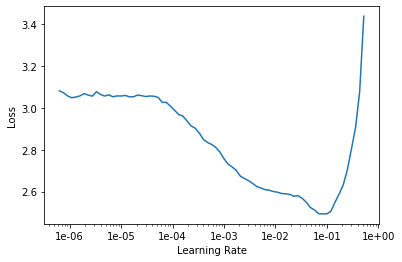

In [35]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.352961,1.140385,0.667633,0.673079,0.699527,00:41
1,1.994871,1.081752,0.709501,0.711361,0.754066,00:37
2,1.808168,1.037399,0.721417,0.722404,0.760263,00:40
3,1.596457,0.901398,0.786473,0.788682,0.813735,00:40
4,1.440425,0.834294,0.814171,0.813478,0.833216,00:41
5,1.339702,0.812591,0.819968,0.823043,0.852854,00:41
6,1.251420,0.780104,0.836393,0.837693,0.860653,00:42
7,1.205174,0.757269,0.850242,0.846872,0.868413,00:40
8,1.177516,0.759770,0.849597,0.844306,0.869217,00:39
9,1.147036,0.751810,0.855072,0.851689,0.872072,00:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


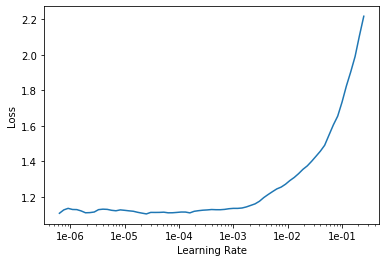

In [39]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(20, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.151588,0.753872,0.854106,0.852041,0.871974,00:39
1,1.133483,0.759214,0.849597,0.843112,0.870223,00:40
2,1.123960,0.756215,0.848631,0.841956,0.870319,00:43
3,1.129055,0.749346,0.852174,0.846512,0.868648,00:41
4,1.133619,0.754509,0.847665,0.842278,0.868418,00:42
5,1.127621,0.739686,0.857005,0.851717,0.874474,00:42
6,1.118166,0.736154,0.858293,0.852803,0.876337,00:42
7,1.104131,0.739390,0.855395,0.850005,0.877407,00:42
8,1.098453,0.734864,0.859903,0.854807,0.877380,00:42
9,1.082309,0.732767,0.859259,0.853790,0.879922,00:41


## MixUp + LabelSmoothing + Fit w/Annealing + Ranger

In [50]:
opt_func  = Ranger
loss_func = LabelSmoothingCrossEntropy()
bs = 64

In [58]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func,
                    callback_fns = partial(SaveModelCallback, monitor='accuracy')).to_fp16()
learn = learn.mixup()

set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 9.12E-02


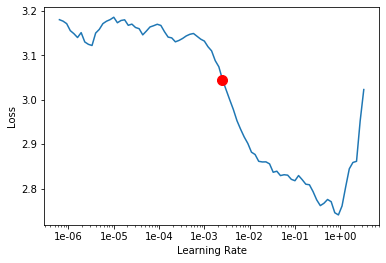

In [54]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [57]:
learn.fit_fc(8, 4e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.176359,1.106088,0.694042,0.705557,0.727720,00:41
1,1.904545,1.020957,0.728180,0.734683,0.766717,00:39
2,1.727587,0.985720,0.750725,0.752720,0.783875,00:39
3,1.594527,0.913824,0.779388,0.776985,0.801938,00:38
4,1.512222,0.876232,0.797423,0.799794,0.822939,00:38
5,1.415469,0.834092,0.819002,0.815807,0.841282,00:38
6,1.341736,0.794460,0.830596,0.827573,0.848995,00:42
7,1.265312,0.783556,0.830918,0.829773,0.850765,00:38


Better model found at epoch 0 with accuracy value: 0.6940418481826782.
Better model found at epoch 1 with accuracy value: 0.7281803488731384.
Better model found at epoch 2 with accuracy value: 0.7507246136665344.
Better model found at epoch 3 with accuracy value: 0.7793880701065063.
Better model found at epoch 4 with accuracy value: 0.7974234819412231.
Better model found at epoch 5 with accuracy value: 0.8190016150474548.
Better model found at epoch 6 with accuracy value: 0.8305957913398743.
Better model found at epoch 7 with accuracy value: 0.8309178948402405.
set state called


In [60]:
learn.load('bestmodel')

set state called


In [64]:
learn.unfreeze()

In [65]:
learn.fit_one_cycle(20, max_lr=5e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.279532,0.884063,0.803865,0.804443,0.836755,00:41
1,1.317193,1.188112,0.713043,0.730310,0.748055,00:40
2,1.320019,0.898378,0.778744,0.802350,0.819837,00:39
3,1.323215,1.194549,0.651852,0.655761,0.654534,00:39
4,1.411251,6.112967,0.188084,0.315261,0.305624,00:38
5,1.612167,1.496085,0.485346,0.494871,0.521427,00:41


Better model found at epoch 0 with accuracy value: 0.8038647174835205.
set state called


KeyboardInterrupt: 

In [67]:
learn.load('bestmodel')
learn.unfreeze();

set state called


In [68]:
learn.fit_fc(15, lr=1e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.207960,0.733019,0.863768,0.860056,0.880178,00:39
1,1.182934,0.717278,0.872142,0.872253,0.886808,00:40
2,1.155278,0.730896,0.863124,0.858660,0.882572,00:41
3,1.135242,0.723596,0.869565,0.865160,0.887082,00:41
4,1.114906,0.728718,0.874718,0.872507,0.889560,00:40
5,1.084055,0.718910,0.868921,0.863393,0.890943,00:39
6,1.062622,0.699950,0.886634,0.882466,0.902128,00:39
7,1.051903,0.716320,0.867633,0.864975,0.886455,00:42
8,1.048614,0.707733,0.874396,0.869092,0.893699,00:40
9,1.030557,0.726429,0.868599,0.872143,0.876097,00:41


Better model found at epoch 0 with accuracy value: 0.8637681007385254.
Better model found at epoch 1 with accuracy value: 0.8721417188644409.
Better model found at epoch 4 with accuracy value: 0.874718189239502.
Better model found at epoch 6 with accuracy value: 0.8866344690322876.
Better model found at epoch 12 with accuracy value: 0.8876006603240967.
Better model found at epoch 13 with accuracy value: 0.895652174949646.
set state called


In [69]:
learn.fit_fc(25, lr=1e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.946402,0.664578,0.894364,0.888344,0.909292,00:38
1,0.956351,0.673482,0.894364,0.890038,0.908338,00:41
2,0.954361,0.680494,0.889855,0.883990,0.904130,00:42
3,0.949147,0.669123,0.896618,0.887645,0.908579,00:43
4,0.948088,0.690289,0.876651,0.871206,0.893537,00:43
5,0.940291,0.677432,0.886312,0.881287,0.901914,00:43
6,0.938775,0.702551,0.878261,0.869044,0.896828,00:45
7,0.933196,0.691382,0.881481,0.876964,0.897929,00:41
8,0.929227,0.691326,0.881804,0.875226,0.897646,00:44
9,0.915933,0.691495,0.888889,0.885254,0.897849,00:42


Better model found at epoch 0 with accuracy value: 0.8943639397621155.
Better model found at epoch 3 with accuracy value: 0.8966183662414551.
set state called


## CutMix + LabelSmoothing + Fit w/Annealing + Ranger

In [70]:
opt_func  = Ranger
loss_func = LabelSmoothingCrossEntropy()
bs = 64

In [76]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func,
                    callback_fns = partial(SaveModelCallback, monitor='accuracy')).to_fp16()
learn = learn.cutmix()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 4.79E-03


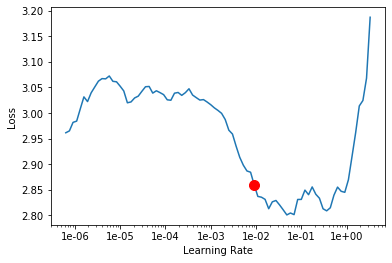

In [74]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [77]:
learn.fit_fc(10, 8e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.361482,1.108103,0.702738,0.709993,0.730145,00:43
1,2.021058,1.004269,0.741063,0.743768,0.769429,00:42
2,1.742025,0.930083,0.775845,0.779424,0.794811,00:44
3,1.571086,0.877857,0.791948,0.795836,0.822312,00:41
4,1.456934,0.833501,0.807729,0.807152,0.836828,00:41
5,1.347280,0.790156,0.834461,0.832988,0.859108,00:38
6,1.286309,0.776158,0.836071,0.832681,0.852729,00:39
7,1.262419,0.778706,0.849597,0.846444,0.865802,00:45
8,1.195181,0.752323,0.855395,0.849356,0.875331,00:43
9,1.155328,0.734106,0.863768,0.858175,0.881556,00:42


Better model found at epoch 0 with accuracy value: 0.7027375102043152.
Better model found at epoch 1 with accuracy value: 0.7410628199577332.
Better model found at epoch 2 with accuracy value: 0.7758454084396362.
Better model found at epoch 3 with accuracy value: 0.7919484972953796.
Better model found at epoch 4 with accuracy value: 0.8077294826507568.
Better model found at epoch 5 with accuracy value: 0.8344605565071106.
Better model found at epoch 6 with accuracy value: 0.8360708355903625.
Better model found at epoch 7 with accuracy value: 0.8495973944664001.
Better model found at epoch 8 with accuracy value: 0.8553945422172546.
Better model found at epoch 9 with accuracy value: 0.8637681007385254.
set state called


In [78]:
learn.unfreeze();
learn.fit_fc(25, lr=1e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.088912,0.740034,0.864734,0.856177,0.879477,00:40
1,1.102651,0.717391,0.873108,0.867926,0.887064,00:43
2,1.130982,0.715434,0.870209,0.863019,0.883746,00:41
3,1.097420,0.715693,0.871820,0.862273,0.889587,00:41
4,1.057166,0.695126,0.877295,0.872163,0.894652,00:41
5,1.078776,0.706879,0.873752,0.866894,0.890873,00:40
6,1.067177,0.699045,0.883414,0.882207,0.896383,00:40
7,1.063264,0.701699,0.876973,0.871696,0.896530,00:39
8,1.031107,0.715240,0.869565,0.863181,0.893482,00:42
9,1.025619,0.708177,0.877295,0.871278,0.890405,00:41


Better model found at epoch 0 with accuracy value: 0.8647342920303345.
Better model found at epoch 1 with accuracy value: 0.87310791015625.
Better model found at epoch 4 with accuracy value: 0.877294659614563.
Better model found at epoch 6 with accuracy value: 0.8834138512611389.
Better model found at epoch 13 with accuracy value: 0.8856682777404785.
Better model found at epoch 16 with accuracy value: 0.886956512928009.
set state called


In [80]:
learn.load('bestmodel');

set state called


set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


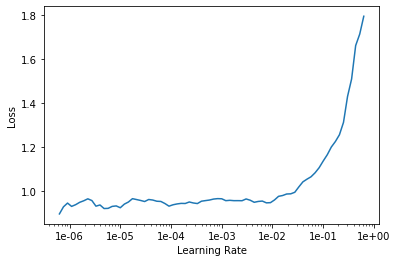

In [81]:
learn.lr_find()
learn.recorder.plot()

In [89]:
learn.fit_one_cycle(15, slice(1e-6, 1e-4), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.939340,0.682806,0.889211,0.887994,0.900182,00:43
1,0.949782,0.680479,0.888245,0.886772,0.898148,00:42
2,0.919268,0.681224,0.888245,0.886246,0.899044,00:40
3,0.909344,0.683729,0.888245,0.885343,0.900934,00:38


Better model found at epoch 0 with accuracy value: 0.8892109394073486.
set state called


KeyboardInterrupt: 

In [91]:
learn.load('bestmodel');

set state called


In [92]:
learn.fit_one_cycle(15, slice(1e-6, 1e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.939078,0.677749,0.888889,0.889000,0.898819,00:42
1,0.947228,0.688204,0.887601,0.884603,0.900346,00:39
2,0.941331,0.686818,0.890177,0.886308,0.903371,00:42
3,0.923090,0.698331,0.878583,0.875124,0.898201,00:43
4,0.905118,0.679252,0.888245,0.885924,0.901254,00:42
5,0.916545,0.685905,0.883736,0.880721,0.898661,00:39
6,0.916300,0.684249,0.883092,0.876998,0.897820,00:42
7,0.899779,0.681219,0.885346,0.884165,0.901410,00:43
8,0.917519,0.688947,0.884058,0.879035,0.899259,00:42
9,0.918829,0.693035,0.885668,0.880556,0.901647,00:44


Better model found at epoch 0 with accuracy value: 0.8888888955116272.
Better model found at epoch 2 with accuracy value: 0.8901771306991577.
set state called
